In [57]:
import numpy as np
import time, os, sys
from glob import glob
from tifffile import imread
from tqdm import tqdm

from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
# mpl.rcParams['figure.dpi'] = 96
%config InlineBackend.figure_format = 'retina'

from cellpose import utils, models, transforms

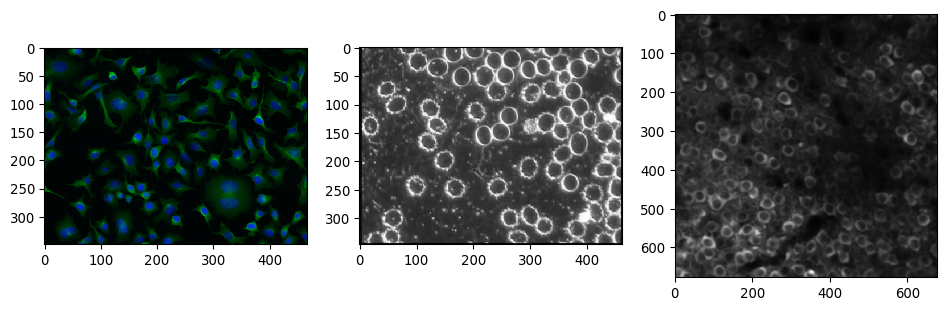

In [9]:
# I will download images from website
urls = ['http://www.cellpose.org/static/images/img02.png',
        'http://www.cellpose.org/static/images/img03.png',
        'http://www.cellpose.org/static/images/img05.png']
files = []
for url in urls:
    parts = urlparse(url)
    filename = os.path.basename(parts.path)
    if not os.path.exists(filename):
        sys.stderr.write('Downloading: "{}" to {}\n'.format(url, filename))
        utils.download_url_to_file(url, filename)
    files.append(filename)

# REPLACE FILES WITH YOUR IMAGE PATHS
# files = ['img0.tif', 'img1.tif']
    
imgs = [skimage.io.imread(f) for f in files]
nimg = len(imgs)

plt.figure(figsize=(12,4))
for k,img in enumerate(imgs):
    plt.subplot(1,3,k+1)
    plt.imshow(img)

In [39]:
def random_label_cmap(n=2**16):
    import matplotlib
    import colorsys
    # cols = np.random.rand(n,3)
    # cols = np.random.uniform(0.1,1.0,(n,3))
    h,l,s = np.random.uniform(0,1,n), 0.4 + np.random.uniform(0,0.6,n), 0.2 + np.random.uniform(0,0.8,n)
    cols = np.stack([colorsys.hls_to_rgb(_h,_l,_s) for _h,_l,_s in zip(h,l,s)],axis=0)
    cols[0] = 0
    return matplotlib.colors.ListedColormap(cols)

lbl_cmap = random_label_cmap()

In [72]:
def show_predict(img, model, net_avg=False, d=None, f_thr = 0.4, p_thr=0.0, figsize=(15,15)):
    x = transforms.reshape(img, channels=0)
    masks, *_, diams = model.eval(x, channels=None, diameter=d, 
                                  net_avg=net_avg, tile=True, 
                                  flow_threshold=f_thr, 
                                  cellprob_threshold=p_thr)
    
    print(f'estimated object diamter: {diams}')
    
    plt.figure(figsize=figsize)
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(img, cmap='gray')
    plt.imshow(masks, cmap=lbl_cmap, alpha=0.5)
    plt.axis('off')

In [78]:
def plot_ori_mask(img, mask, figsize=(15,15)):
    plt.figure(figsize=figsize)
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(img, cmap='gray')
    plt.imshow(mask, cmap=lbl_cmap, alpha=0.5)
    plt.axis('off')

(349, 467)


(-0.5, 466.5, 348.5, -0.5)

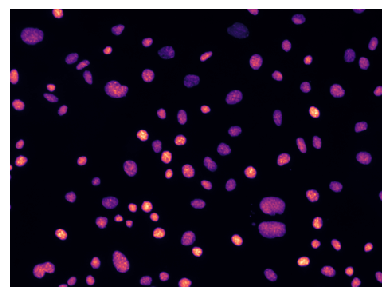

In [17]:
img = imgs[0][...,2]
print(img.shape)
plt.figure(figsize=(5,5))
plt.imshow(img, cmap='magma')
plt.axis('off')

In [63]:
model = models.Cellpose(net_avg=True, batch_size=1, model_type='nuclei')
type(model)

>>>> using CPU


cellpose.models.Cellpose

In [28]:
x = transforms.reshape(img, channels=0)
x.shape

(2, 349, 467)

For input with dim==2 (w/o channel, grayscale), the channels need to be set as [0,0]. or the inputs need to be reshaped to channelxHxW so that eval can take channels as None. 

For size estimation (diameter=None), tile need to be set True

In [30]:
# the pretrained model only take input with channel = 2, and for size prediction, the input need to be tiled
masks, flows, styles, diams = model.eval(x, channels=None, diameter=None, net_avg=False, tile=True)

  0%|          | 0/1 [00:00<?, ?it/s]

processing 1 images


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


estimated cell diameters for all images


  0%|          | 0/1 [00:00<?, ?it/s]

processing 1 images


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


estimated cell diameters for all images
estimated object diamter: 13.750474046971023


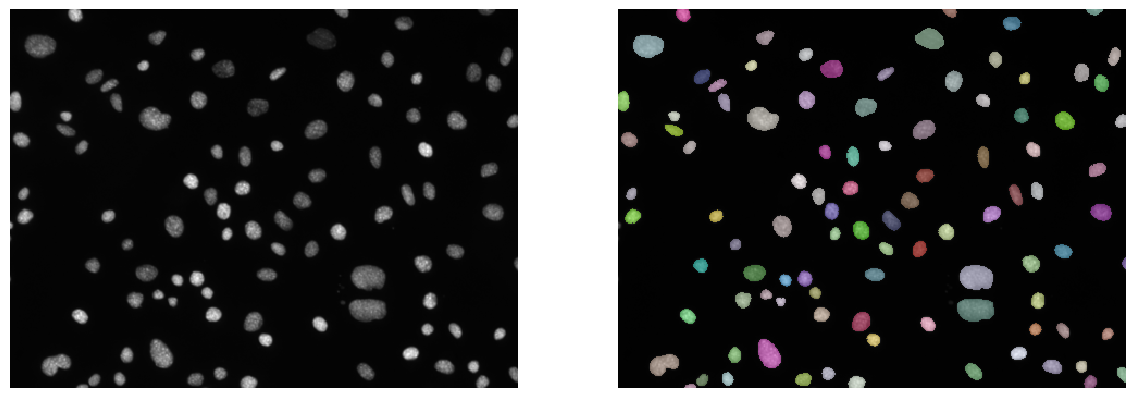

In [47]:
show_predict(img, model)

In [ ]:
# X = sorted(glob('/home/qzt/data/centuri/train/images/*.tif'))
# Y = sorted(glob('/home/qzt/data/centuri/train/masks/*.tif'))
X = sorted(glob('/home/qzt/data/dsb2018/train/images/*.tif'))
# Y = sorted(glob('/home/qzt/data/dsb2018/train/masks/*.tif'))

X_file = [os.path.split(f)[-1] for f in X]
# assert all(Path(x).name==Path(y).name for x,y in zip(X,Y_file))
print(X_file[0])

In [59]:
HOME = '/home/qzt'
PATH = "data/dsb2018/dsb2018_sub1/"
# PATH = "data/centuri/train/"
# path = os.path.join(HOME, "data/dsb2018/dsb2018_sub1/images/*.tif")
pathX = os.path.join(HOME, PATH+"images/*.tif")
pathY = os.path.join(HOME, PATH+"masks/*.tif")
X_file = sorted(glob(pathX))
Y_file = sorted(glob(pathY))
print(len(X_file), len(Y_file))

X = list(map(imread,X_file))
Y = list(map(imread,Y_file))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

# X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
# Y = [fill_label_holes(y) for y in tqdm(Y)]

292 292


In [60]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]

### manual assign train/val index for debugging
# ind_train = [1,2,3,4]
# ind_val = [0]

X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 292
- training:       248
- validation:      44


In [95]:
img = X_val[1]
x = transforms.reshape(img, channels=0)
masks, flows, styles, diams = model.eval(x, channels=None, diameter=None, 
                              net_avg=True, tile=True, 
                              flow_threshold=0.4, 
                              cellprob_threshold=0.0)
print(f'estimated object diamter: {diams}')

  0%|          | 0/1 [00:00<?, ?it/s]

processing 1 images


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


estimated cell diameters for all images
estimated object diamter: 44.352622206762774


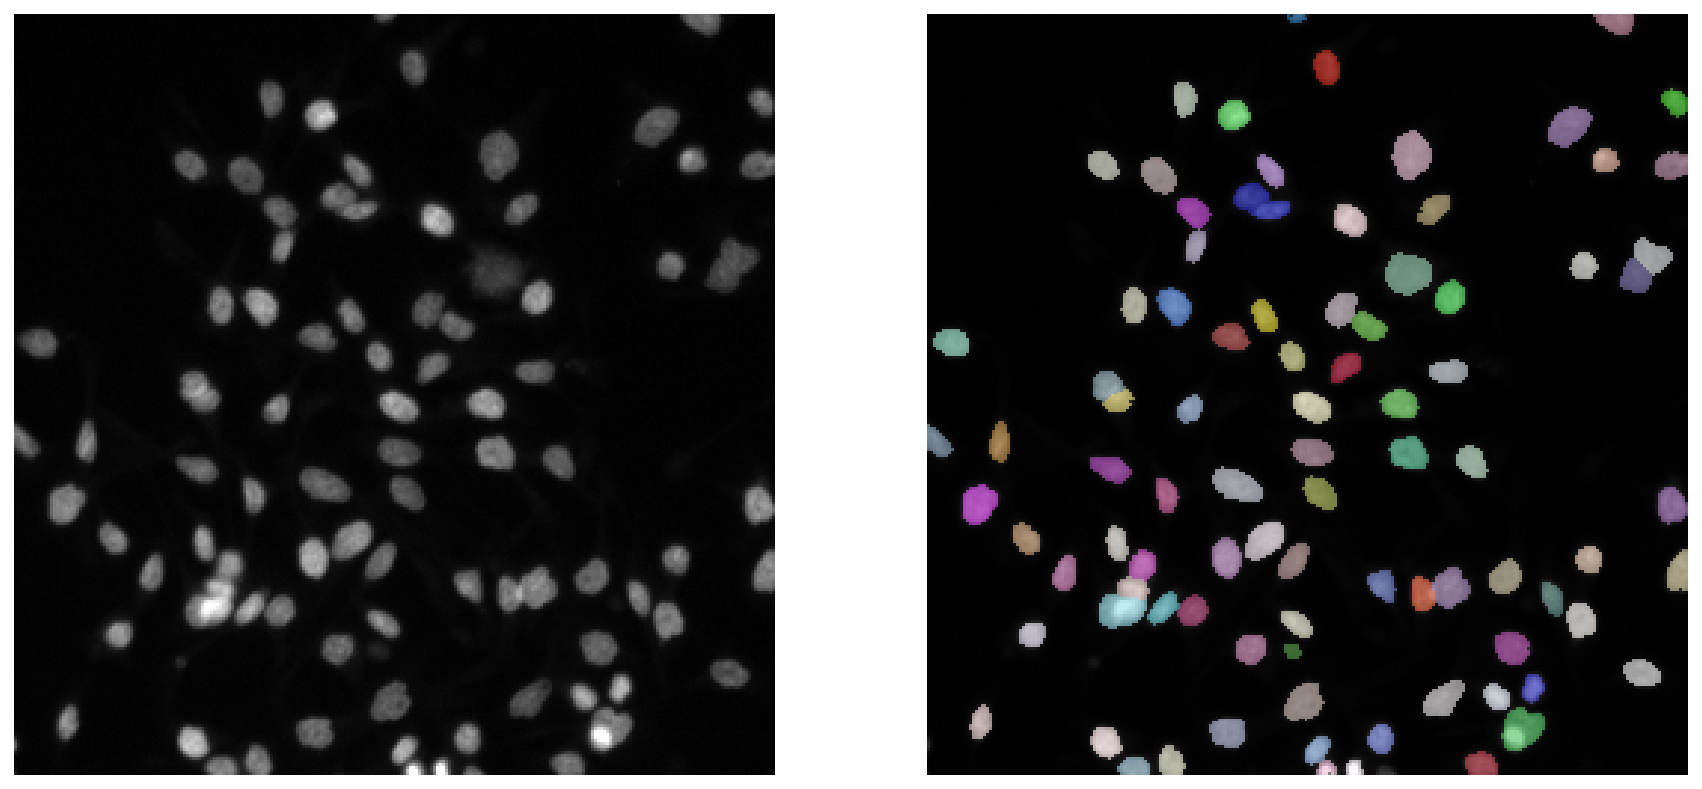

In [79]:
plot_ori_mask(img, masks)

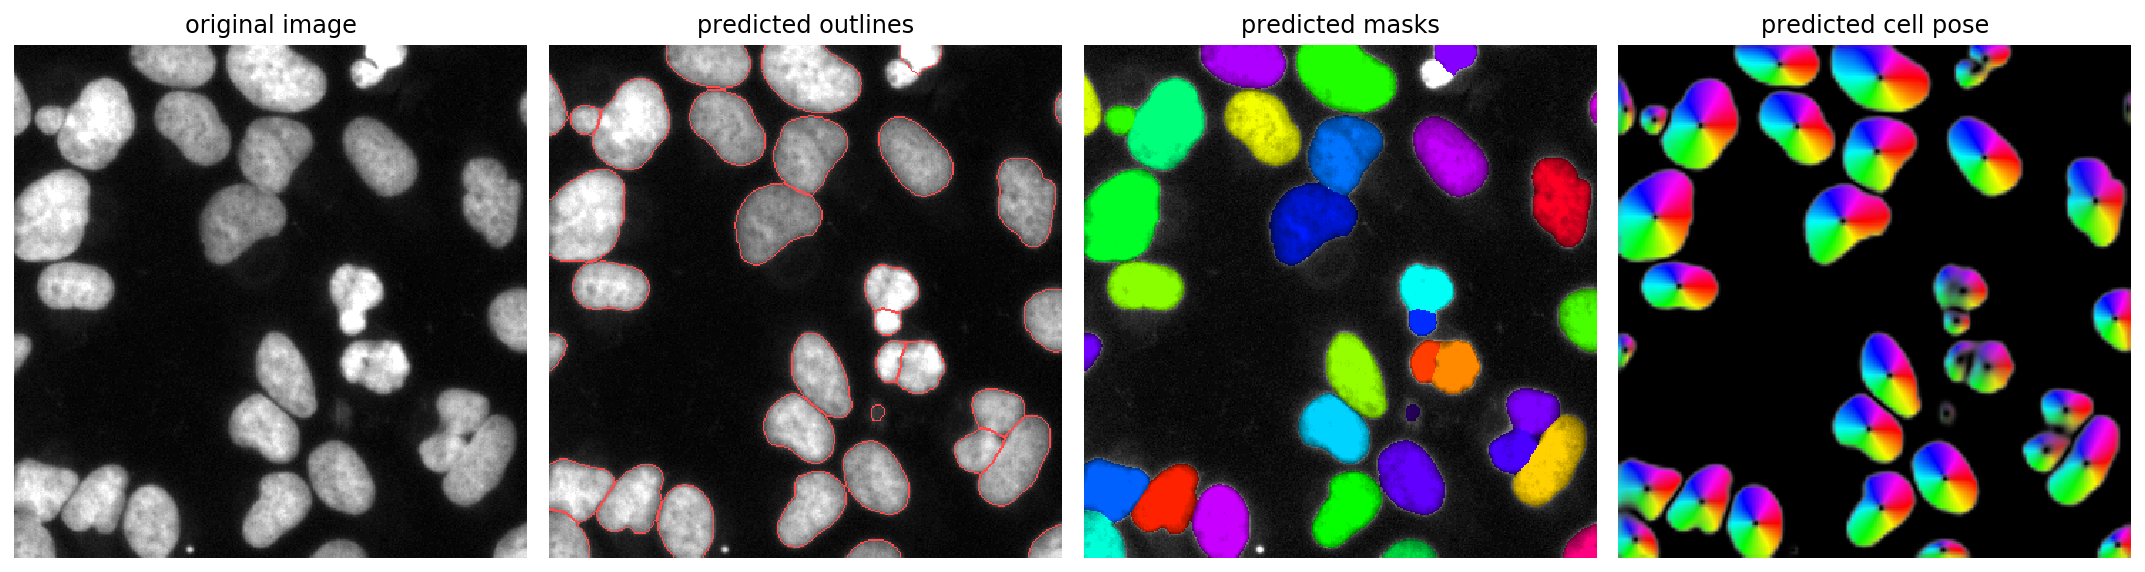

In [96]:
from cellpose import plot

fig = plt.figure(figsize=(15,15))
plot.show_segmentation(fig, img, masks, flows[0], channels=[0,0])
plt.tight_layout()
plt.show()